In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    classification_report
)
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize
from statsmodels.stats.power import NormalIndPower

In [3]:
# Load the CSV files into DataFrames
email_table = pd.read_csv('https://raw.githubusercontent.com/KanchanMaan/Email_Campaign_case_study/refs/heads/main/email_campaign_files/email_table.csv')
email_opened = pd.read_csv('https://raw.githubusercontent.com/KanchanMaan/Email_Campaign_case_study/refs/heads/main/email_campaign_files/email_opened_table.csv')
link_clicked = pd.read_csv('https://raw.githubusercontent.com/KanchanMaan/Email_Campaign_case_study/refs/heads/main/email_campaign_files/link_clicked_table.csv')

# Display initial rows (optional)
print("Email Table Preview:")
print(email_table.head(4))

# Create binary indicator columns:
# 'opened' is 1 if the email_id exists in the email_opened_table, else 0
email_table['opened'] = email_table['email_id'].isin(email_opened['email_id']).astype(int)

# 'clicked' is 1 if the email_id exists in the link_clicked_table, else 0
email_table['clicked'] = email_table['email_id'].isin(link_clicked['email_id']).astype(int)

# Inspect the merged data with the new binary columns
print("\nMerged Table with 'opened' and 'clicked' indicators:")
print(email_table.head(4))


Email Table Preview:
   email_id   email_text email_version  hour    weekday user_country  \
0     85120  short_email  personalized     2     Sunday           US   
1    966622   long_email  personalized    12     Sunday           UK   
2    777221   long_email  personalized    11  Wednesday           US   
3    493711  short_email       generic     6     Monday           UK   

   user_past_purchases  
0                    5  
1                    2  
2                    2  
3                    1  

Merged Table with 'opened' and 'clicked' indicators:
   email_id   email_text email_version  hour    weekday user_country  \
0     85120  short_email  personalized     2     Sunday           US   
1    966622   long_email  personalized    12     Sunday           UK   
2    777221   long_email  personalized    11  Wednesday           US   
3    493711  short_email       generic     6     Monday           UK   

   user_past_purchases  opened  clicked  
0                    5       0      

In [3]:
email_table.shape

(100000, 9)

In [4]:
email_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
 7   opened               100000 non-null  int64 
 8   clicked              100000 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 6.9+ MB


In [14]:
email_table.describe(include='all')

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
count,100000.000000,100000,100000,100000.000000,100000,100000,100000.00000,100000.000000,100000.000000
unique,NaN,2,2,NaN,7,4,NaN,NaN,NaN
top,NaN,long_email,generic,NaN,Saturday,US,NaN,NaN,NaN
freq,NaN,50276,50209,NaN,14569,60099,NaN,NaN,NaN
mean,498690.196160,NaN,NaN,9.059300,NaN,NaN,3.87845,0.103450,0.021190
std,289230.727534,NaN,NaN,4.439637,NaN,NaN,3.19611,0.304547,0.144018
min,8.000000,NaN,NaN,1.000000,NaN,NaN,0.00000,0.000000,0.000000
25%,246708.250000,NaN,NaN,6.000000,NaN,NaN,1.00000,0.000000,0.000000
50%,498447.000000,NaN,NaN,9.000000,NaN,NaN,3.00000,0.000000,0.000000
75%,749942.750000,NaN,NaN,12.000000,NaN,NaN,6.00000,0.000000,0.000000


**Campaign Metrics**

In [6]:
# Calculate overall campaign metrics

# Total number of emails sent
total_emails = email_table.shape[0]

# Number of emails that were opened
opened_emails = email_table['opened'].sum()

# Number of emails where the link was clicked
clicked_emails = email_table['clicked'].sum()

# Open Rate: Percentage of emails that were opened
open_rate = opened_emails / total_emails

# Click-Through Rate (CTR): Percentage of emails that led to a click
ctr = clicked_emails / total_emails

print(f"Total Emails Sent: {total_emails}")
print(f"Emails Opened: {opened_emails} ({open_rate*100:.2f}%)")
print(f"Emails Clicked: {clicked_emails} ({ctr*100:.2f}%)")

Total Emails Sent: 100000
Emails Opened: 10345 (10.35%)
Emails Clicked: 2119 (2.12%)


**EDA**

In [7]:
email_table.columns

Index(['email_id', 'email_text', 'email_version', 'hour', 'weekday',
       'user_country', 'user_past_purchases', 'opened', 'clicked'],
      dtype='object')

Email Text Distribution:
email_text
long_email     50276
short_email    49724
Name: count, dtype: int64


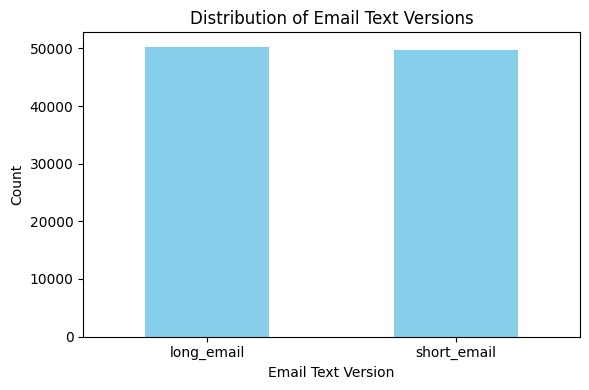

In [9]:
# Distribution of email_text types (long vs short)
text_counts = email_table['email_text'].value_counts()
print("Email Text Distribution:")
print(text_counts)

plt.figure(figsize=(6,4))
text_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Email Text Versions')
plt.xlabel('Email Text Version')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Email Version Distribution:
email_version
generic         50209
personalized    49791
Name: count, dtype: int64


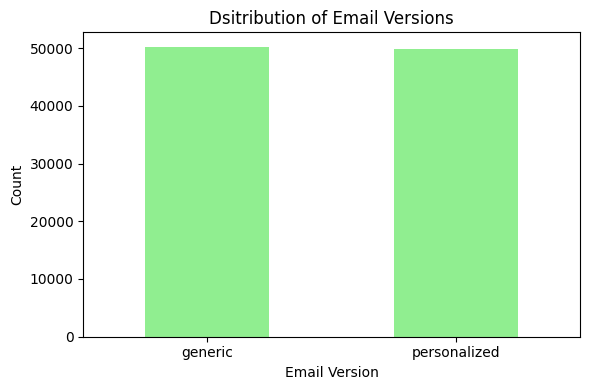

In [10]:
# Distibution of email_version (personlized vs generic)
version_counts = email_table['email_version'].value_counts()
print("Email Version Distribution:")
print(version_counts)

plt.figure(figsize=(6,4))
version_counts.plot(kind='bar', color='lightgreen')
plt.title('Dsitribution of Email Versions')
plt.xlabel('Email Version')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [11]:
email_table['weekday'].value_counts()

weekday
Saturday     14569
Sunday       14387
Monday       14363
Thursday     14277
Friday       14177
Tuesday      14143
Wednesday    14084
Name: count, dtype: int64

In [12]:
email_table['user_country'].value_counts()

user_country
US    60099
UK    19939
FR     9995
ES     9967
Name: count, dtype: int64

In [13]:
email_table['hour'].value_counts()

hour
9     8529
8     8398
7     8204
10    8180
11    7483
6     7465
5     6551
12    6508
4     5622
13    5581
3     4610
14    4580
2     3676
15    3493
16    2759
1     2703
17    1893
18    1421
19     905
20     656
21     365
22     204
23     145
24      69
Name: count, dtype: int64

**Grouped Campaign Performance Metrics**

In [15]:
# Fucntion to compute performance metrics by grouping variable
def compute_performance(df, group_col):
    grouped = df.groupby(group_col).agg(
        total_emails = ('email_id', 'count'),
        opened_emails = ('opened', 'sum'),
        clicked_emails = ('clicked', 'sum')
    )
    grouped['open_rate'] = grouped['opened_emails']/grouped['total_emails']
    grouped['ctr'] = grouped['clicked_emails']/grouped['total_emails']
    return grouped

# Performance by email_version
performance_version = compute_performance(email_table, 'email_version')
print("Performance Metrics by Email Version:")
print(performance_version)

# Performance by weekday 
performance_weekday = compute_performance(email_table, 'weekday')
print("\nPerformance Metrics by Weekday:")
print(performance_weekday)

# Performance by weekday
performance_text = compute_performance(email_table, 'email_text')
print("\nPerformance Metrics by Email Text:")
print(performance_text)

Performance Metrics by Email Version:
               total_emails  opened_emails  clicked_emails  open_rate  \
email_version                                                           
generic               50209           3984             760   0.079348   
personalized          49791           6361            1359   0.127754   

                    ctr  
email_version            
generic        0.015137  
personalized   0.027294  

Performance Metrics by Weekday:
           total_emails  opened_emails  clicked_emails  open_rate       ctr
weekday                                                                    
Friday            14177           1051             199   0.074134  0.014037
Monday            14363           1667             329   0.116062  0.022906
Saturday          14569           1277             260   0.087652  0.017846
Sunday            14387           1261             241   0.087649  0.016751
Thursday          14277           1691             349   0.118442  0.024445


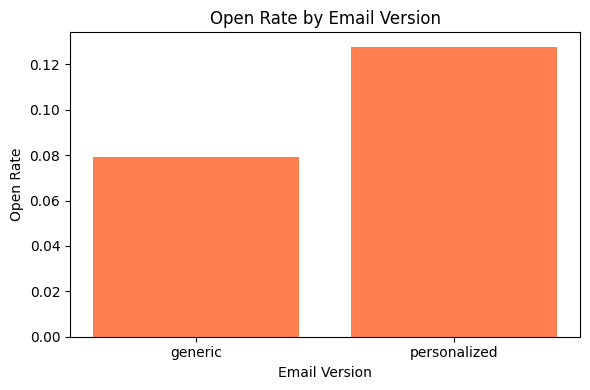

In [16]:
# plot open rate by email version
plt.figure(figsize=(6,4))
plt.bar(performance_version.index, performance_version['open_rate'], color='coral')
plt.title('Open Rate by Email Version')
plt.xlabel('Email Version')
plt.ylabel('Open Rate')
plt.tight_layout()
plt.show()

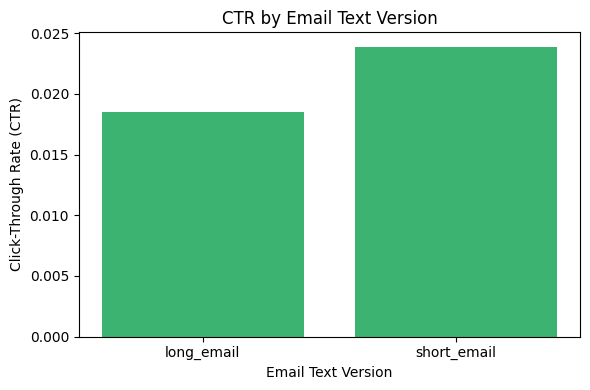

In [17]:
# Plot CTR by Email Text
plt.figure(figsize=(6,4))
plt.bar(performance_text.index, performance_text['ctr'], color='mediumseagreen')
plt.title('CTR by Email Text Version')
plt.xlabel('Email Text Version')
plt.ylabel('Click-Through Rate (CTR)')
plt.tight_layout()
plt.show()


**Temporal Analysis (by hour)**

Performance Metrics by Hour:
      total_emails  opened_emails  clicked_emails  open_rate       ctr
hour                                                                  
1             2703            239              49   0.088420  0.018128
2             3676            323              60   0.087867  0.016322
3             4610            390              90   0.084599  0.019523
4             5622            496              91   0.088225  0.016186
5             6551            538             118   0.082125  0.018013
6             7465            674             128   0.090288  0.017147
7             8204            739             150   0.090078  0.018284
8             8398            743             159   0.088473  0.018933
9             8529           1072             220   0.125689  0.025794
10            8180           1083             231   0.132396  0.028240
11            7483            947             203   0.126554  0.027128
12            6508            810             16

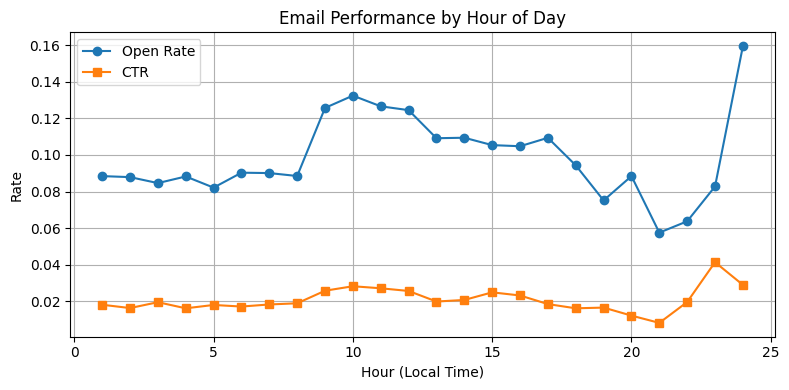

In [18]:
performance_hour = email_table.groupby('hour').agg(
    total_emails=('email_id', 'count'),
    opened_emails=('opened', 'sum'),
    clicked_emails=('clicked', 'sum')
)
performance_hour['open_rate'] = performance_hour['opened_emails'] / performance_hour['total_emails']
performance_hour['ctr'] = performance_hour['clicked_emails'] / performance_hour['total_emails']
print("Performance Metrics by Hour:")
print(performance_hour)

plt.figure(figsize=(8,4))
plt.plot(performance_hour.index, performance_hour['open_rate'], marker='o', label='Open Rate')
plt.plot(performance_hour.index, performance_hour['ctr'], marker='s', label='CTR')
plt.title('Email Performance by Hour of Day')
plt.xlabel('Hour (Local Time)')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Segmentation by User Attributes**

Performance Metrics by Countries:
              total_emails  opened_emails  clicked_emails  open_rate       ctr
user_country                                                                  
ES                    9967            390              83   0.039129  0.008327
FR                    9995            406              80   0.040620  0.008004
UK                   19939           2396             492   0.120167  0.024675
US                   60099           7153            1464   0.119020  0.024360


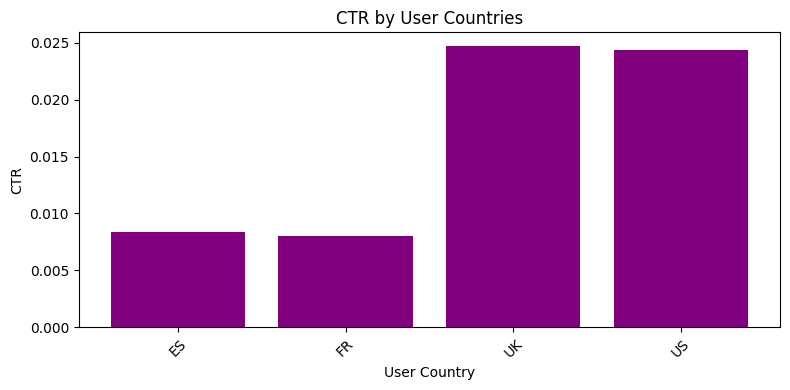

In [19]:
top_countries = email_table['user_country'].value_counts().index
performance_country = compute_performance(email_table[email_table['user_country'].isin(top_countries)], 'user_country')
print("Performance Metrics by Countries:")
print(performance_country)

plt.figure(figsize=(8,4))
plt.bar(performance_country.index, performance_country['ctr'], color='purple')
plt.title('CTR by User Countries')
plt.xlabel('User Country')
plt.ylabel('CTR')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Feature Engineering**

In [20]:
# User segment: purchase history quartiles
email_table['purchase_bin'] = pd.qcut(
    email_table['user_past_purchases'].fillna(0),
    q=4,
    labels=['Low', 'Mid-Low', 'Mid-High', 'High']
)
print("Performance by past-purchase quartile:")
print(compute_performance(email_table, 'purchase_bin'), "\n")

Performance by past-purchase quartile:
              total_emails  opened_emails  clicked_emails  open_rate       ctr
purchase_bin                                                                  
Low                  27628           1808             161   0.065441  0.005827
Mid-Low              25113           2625             400   0.104528  0.015928
Mid-High             27303           3175             672   0.116288  0.024613
High                 19956           2737             886   0.137152  0.044398 



C:\Users\KANCHAN MAAN\AppData\Local\Temp\ipykernel_21124\415305367.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(group_col).agg(


In [21]:
df = email_table.copy()
categorical_cols = ['email_text', 'email_version', 'weekday', 'user_country', 'purchase_bin']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Interaction feature: personalized × high-purchase
if 'email_version_personalized' in df.columns and 'purchase_bin_High' in df.columns:
    df['personalized_x_high'] = df['email_version_personalized'] * df['purchase_bin_High']


In [22]:
df

,email_id,hour,user_past_purchases,opened,clicked,email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US,purchase_bin_Mid-Low,purchase_bin_Mid-High,purchase_bin_High,personalized_x_high
0,85120,2,5,0,0,True,True,False,False,True,False,False,False,False,False,True,False,True,False,False
1,966622,12,2,1,1,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False
2,777221,11,2,0,0,False,True,False,False,False,False,False,True,False,False,True,True,False,False,False
3,493711,6,1,0,0,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False
4,106887,14,6,0,0,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,803504,4,5,0,0,True,True,True,False,False,False,False,False,False,False,True,False,True,False,False
99996,899722,7,1,0,0,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False
99997,449610,11,6,0,0,False,True,False,True,False,False,False,False,False,True,False,False,True,False,False
99998,72497,10,0,0,0,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False


In [23]:
# Define features and target
X = df.drop(columns=['email_id', 'opened', 'clicked'])
y = df['clicked']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

**Model Evaluation**

=== Model Performance Metrics ===
Accuracy: 0.98
ROC AUC: 0.74

Confusion Matrix:
[[29364     0]
 [  636     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     29364
           1       0.00      0.00      0.00       636

    accuracy                           0.98     30000
   macro avg       0.49      0.50      0.49     30000
weighted avg       0.96      0.98      0.97     30000



C:\Users\KANCHAN MAAN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\KANCHAN MAAN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\KANCHAN MAAN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

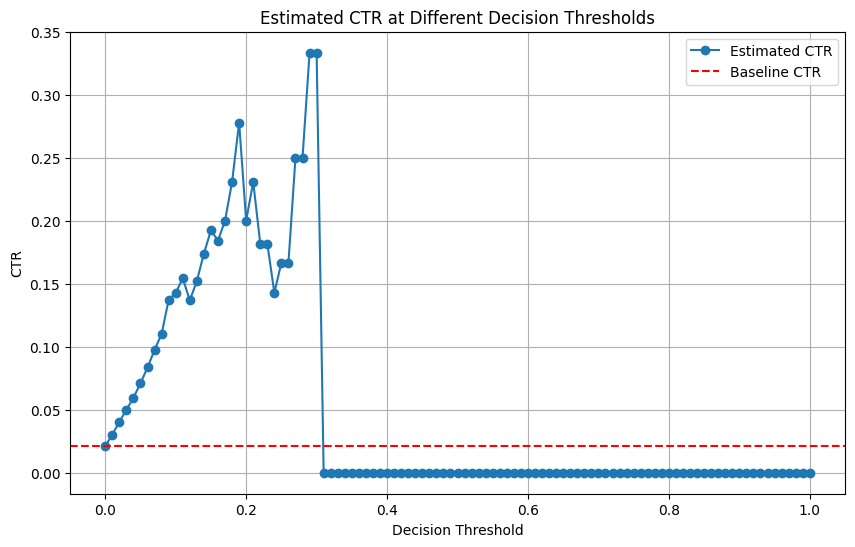

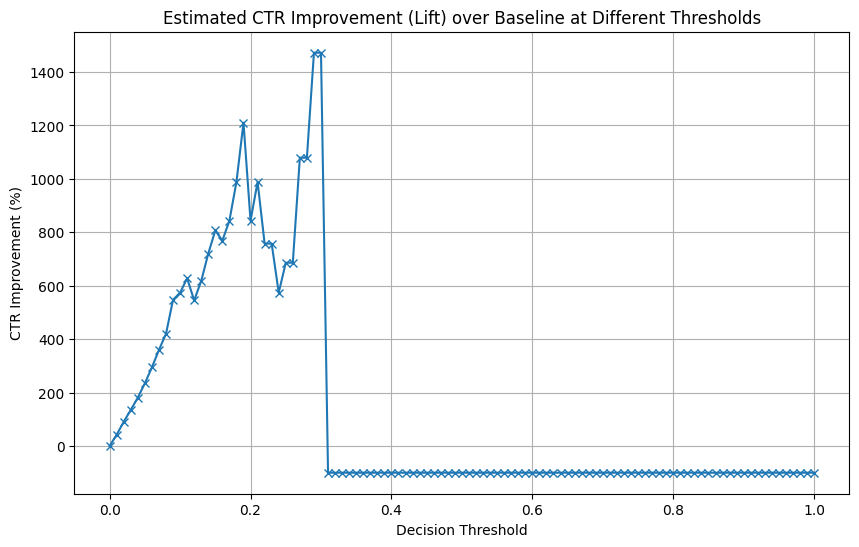

In [30]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set.
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class.

# Compute evaluation metrics.
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("=== Model Performance Metrics ===")
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print("\nConfusion Matrix:")
print(conf_mat)
print("\nClassification Report:")
print(report)

# Baseline CTR on the test set 
baseline_ctr = y_test.mean()

# Range of thresholds to explore
thresholds = np.linspace(0, 1, 101)

# Lists to store results for each threshold
estimated_ctrs = []
lift_values = []
selected_counts = []

for thresh in thresholds:
    # Predict positive if the predicted probability is at or above the current threshold
    selected_mask = y_prob >= thresh
    selected_count = selected_mask.sum()
    selected_counts.append(selected_count)
    
    # Calculate the CTR among the selected emails. If no emails are selected, set CTR to 0.
    if selected_count > 0:
        selected_ctr = y_test[selected_mask].mean()
    else:
        selected_ctr = 0
    estimated_ctrs.append(selected_ctr)
    
    # Calculate the relative improvement (lift) over the baseline CTR (in percentage)
    lift = ((selected_ctr - baseline_ctr) / baseline_ctr) * 100 if baseline_ctr > 0 else 0
    lift_values.append(lift)

# Plotting the estimated CTR for different thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, estimated_ctrs, marker='o', label="Estimated CTR")
plt.axhline(baseline_ctr, color='red', linestyle='--', label="Baseline CTR")
plt.xlabel("Decision Threshold")
plt.ylabel("CTR")
plt.title("Estimated CTR at Different Decision Thresholds")
plt.legend()
plt.grid(True)
plt.show()

# Plotting the estimated CTR improvement (lift) over baseline
plt.figure(figsize=(10, 6))
plt.plot(thresholds, lift_values, marker='x')
plt.xlabel("Decision Threshold")
plt.ylabel("CTR Improvement (%)")
plt.title("Estimated CTR Improvement (Lift) over Baseline at Different Thresholds")
plt.grid(True)
plt.show()


**A/B Testing**

C:\Users\KANCHAN MAAN\AppData\Local\Temp\ipykernel_21124\415305367.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(group_col).agg(


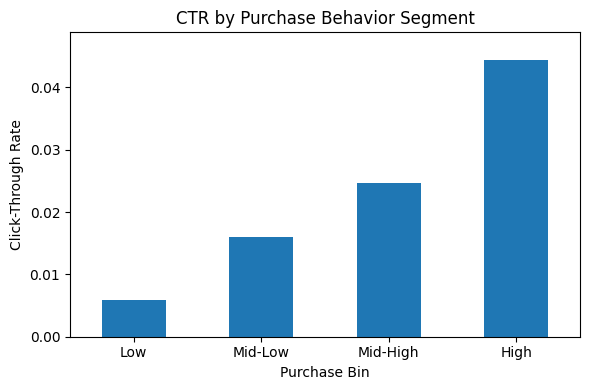

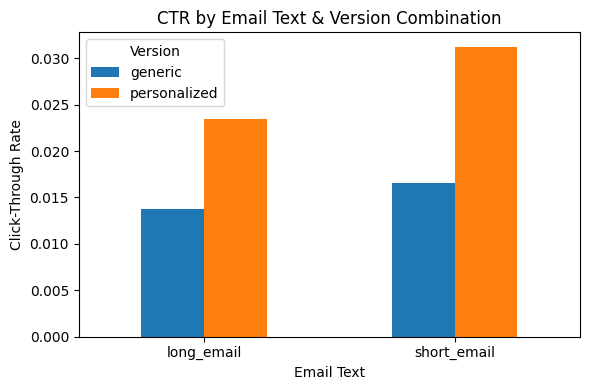

In [34]:
# Segment by user past purchases
email_table['purchase_bin'] = pd.qcut(email_table['user_past_purchases'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])
perf_purchase = compute_performance(email_table, 'purchase_bin')

# Plot CTR by purchase behavior segment
fig, ax = plt.subplots(figsize=(6,4))
perf_purchase['ctr'].plot(kind='bar', ax=ax)
ax.set_title('CTR by Purchase Behavior Segment')
ax.set_xlabel('Purchase Bin')
ax.set_ylabel('Click-Through Rate')
ax.set_ylim(0, perf_purchase['ctr'].max() * 1.1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# crosstab of email text vs email version
ct = email_table.groupby(['email_text', 'email_version']).agg(
    total_emails=('email_id', 'count'),
    clicked_emails=('clicked', 'sum')
)
ct['ctr'] = ct['clicked_emails'] / ct['total_emails']
ctr_table = ct['ctr'].unstack()

# Plot CTR for each combination
fig2, ax2 = plt.subplots(figsize=(6,4))
ctr_table.plot(kind='bar', ax=ax2)
ax2.set_title('CTR by Email Text & Version Combination')
ax2.set_xlabel('Email Text')
ax2.set_ylabel('Click-Through Rate')
plt.xticks(rotation=0)
ax2.legend(title='Version')
plt.tight_layout()
plt.show()

**Model Evalutation**

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     29364
           1       0.03      0.14      0.05       636

    accuracy                           0.89     30000
   macro avg       0.51      0.53      0.50     30000
weighted avg       0.96      0.89      0.93     30000

ROC AUC: 0.588
Average Precision (PR AUC): 0.028


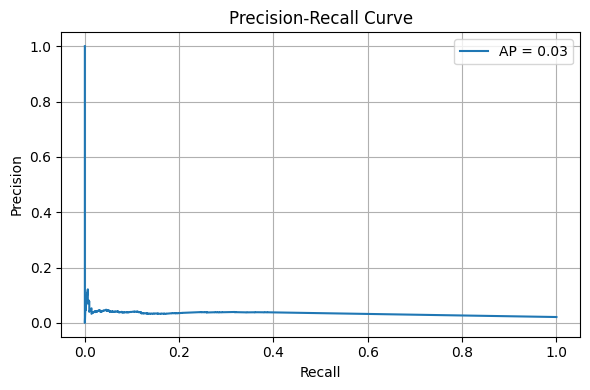

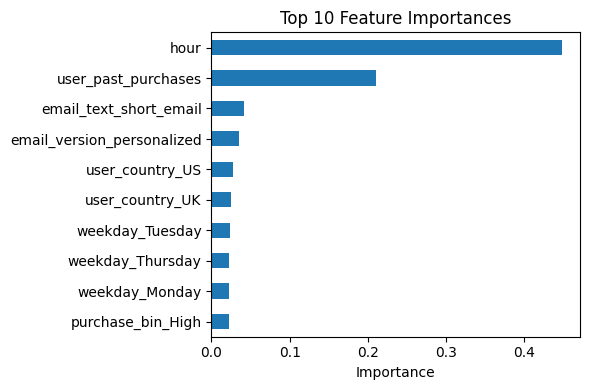

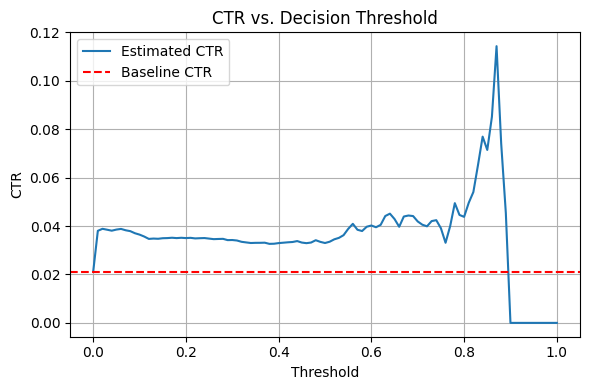

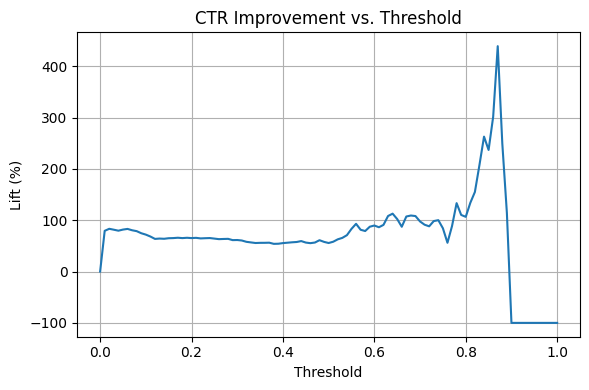

In [35]:
# Train Random Forest with class_weight balanced
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Evaluation metrics
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

roc_auc = roc_auc_score(y_test, y_prob)
avg_prec = average_precision_score(y_test, y_prob)
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Average Precision (PR AUC): {avg_prec:.3f}")

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f'AP = {avg_prec:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature importances
importances = pd.Series(model.feature_importances_, index=X.columns).nlargest(10)
plt.figure(figsize=(6,4))
importances.plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Threshold-Lift Simulation
baseline_ctr = y_test.mean()
thresholds = np.linspace(0, 1, 101)
ctrs = []
lifts = []
for t in thresholds:
    mask = y_prob >= t
    ct = y_test[mask].mean() if mask.sum() > 0 else 0
    ctrs.append(ct)
    lifts.append((ct - baseline_ctr) / baseline_ctr * 100 if baseline_ctr > 0 else 0)

plt.figure(figsize=(6,4))
plt.plot(thresholds, ctrs, label='Estimated CTR')
plt.axhline(baseline_ctr, color='red', linestyle='--', label='Baseline CTR')
plt.xlabel('Threshold')
plt.ylabel('CTR')
plt.title('CTR vs. Decision Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(thresholds, lifts)
plt.xlabel('Threshold')
plt.ylabel('Lift (%)')
plt.title('CTR Improvement vs. Threshold')
plt.grid(True)
plt.tight_layout()
plt.show()


**A/B Testing**

In [38]:
#  A/B Test Sample Size Calculation
# ----------------------------------------------------------------------------
# Expect lift from baseline 2.12% to ~3.5%
p1 = 0.021  # baseline CTR
p2 = 0.035  # expected CTR under model-driven targeting

effect_size = proportion_effectsize(p2, p1)
# Power analysis parameters
alpha = 0.05  # significance level
power = 0.8   # desired power
ratio = 1.0   # equal sample sizes for control and treatment

# Compute required sample size per group
analysis = NormalIndPower()
n_per_group = analysis.solve_power(effect_size, power=power, alpha=alpha, ratio=ratio)

print(f"Required sample size per group for A/B test: {np.ceil(n_per_group):.0f}\n")

# ------------------------------------------------------------------------------
#  Generate A/B Experiment Assignments
# ------------------------------------------------------------------------------
# Score full dataset
df_full = df.copy()
df_full['score'] = model.predict_proba(X)[:, 1]
email_table['score'] = df_full['score']

# Define threshold and sample
threshold = 0.15
treatment = email_table[email_table['score'] >= threshold]
control = email_table[email_table['score'] < threshold]

sample_size = int(min(len(treatment), len(control), np.ceil(n_per_group)))
treatment_sample = treatment.sample(sample_size, random_state=42)
control_sample = control.sample(sample_size, random_state=42)

assignments = pd.concat([
    treatment_sample.assign(group='treatment'),
    control_sample.assign(group='control')
])[['email_id', 'score', 'group']].sample(frac=1, random_state=42)

assignments.to_csv('experiment_assignments.csv', index=False)
print("A/B Assignment Preview:")
print(assignments.head(), "\n")

# A/B Test Analysis
# ------------------------------------------------------------------------------
results = assignments.merge(
    email_table[['email_id', 'clicked']],
    on='email_id',
    how='left'
)

summary = results.groupby('group')['clicked'].agg([
    ('clicks', 'sum'),
    ('emails_sent', 'count')
])
summary['ctr'] = summary['clicks'] / summary['emails_sent']

# Two-proportion z-test
stat, p_val = proportions_ztest(summary['clicks'], summary['emails_sent'])
summary['z_stat'], summary['p_value'] = stat, p_val

print("A/B Test Results:")
print(summary, "\n")

Required sample size per group for A/B test: 2146

A/B Assignment Preview:
       email_id     score      group
1574     978801  0.000000    control
82094    221149  0.507055  treatment
1241     347369  0.000000    control
38935    454274  0.000000    control
52495    853546  0.000000    control 

A/B Test Results:
           clicks  emails_sent       ctr     z_stat       p_value
group                                                            
control         9         2146  0.004194 -17.016942  6.149961e-65
treatment     295         2146  0.137465 -17.016942  6.149961e-65 

